In [1]:
import sys
sys.path.insert(0, '../backend')
sys.path.insert(0, '../../data')

import numpy as np
import random
import math
import pybnb

# from branch_and_bound_warped_pvar_sequential import BnBWarping
from branch_and_bound_warped_pvar import BnBWarping
from generalized_dtw import Warp
from transformers import *

import matplotlib.pyplot as plt
%matplotlib inline

# Brownian path simulation

In [2]:
def white(steps, width, time=1.):
    mu, sigma = 0, math.sqrt(time / steps) 
    return np.random.normal(mu, sigma, (steps, width))

def brownian(steps, width, time=1.):
    path = np.zeros((steps + 1, width))
    np.cumsum(white(steps, width, time), axis=0, out=path[1:, :])
    return path

# Experiments

In [3]:
# sampling points
m = 9

# generate a code (time re-parameterisation)
def randBinList(m): 
    output = [0]
    while np.cumsum(output)[-1]<m: 
        output.append(random.randint(0,1))
    return output

g_deriv = randBinList(m)
g = np.cumsum(g_deriv) 

# generate a Brownian path
W = brownian(m, 1)

# reparameterise BM
W_rep = np.array([W[k] for k in g])

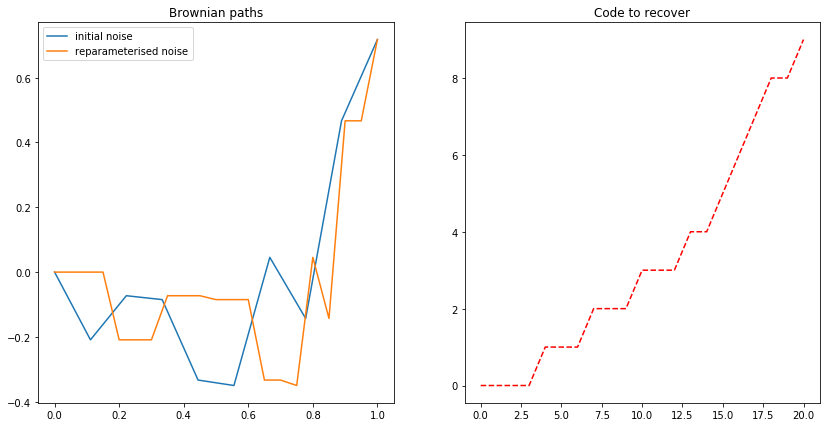

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))
ax[0].plot(np.linspace(0,1,m+1), W, label='initial noise')
ax[0].plot(np.linspace(0,1,len(g)), W_rep, label='reparameterised noise')
ax[0].set_title('Brownian paths')
ax[0].legend()
ax[1].plot(g, c='red', linestyle='--')
ax[1].set_title('Code to recover')
plt.show()

# Dynamic Time Warping

In [5]:
# Euclidean distance
d = lambda a, b: np.sum([x**2 for x in (a-b)])
f_d = lambda DD, a, b: np.sqrt(DD**2 + d(a, b))
final_operator = lambda x: np.sqrt(x)

# Dynamic Time Warping
DTW = Warp(W_rep, W, d, f_d, final_operator, plot_2d=False)

# warping path
dtw_warp = DTW.warping_path
dtw_warp.reverse()

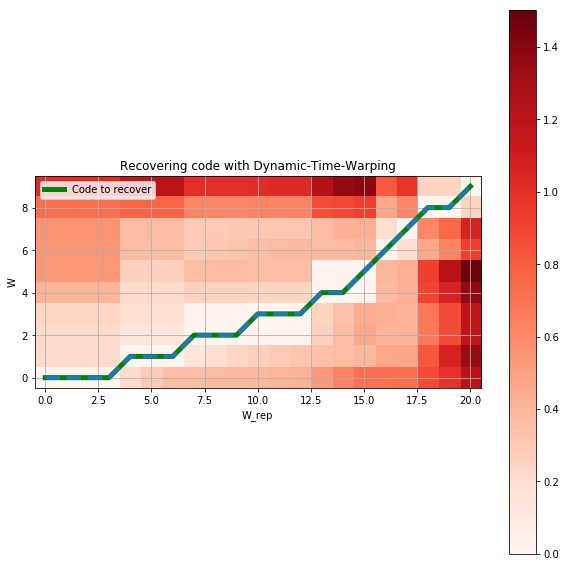

In [6]:
plt.figure(figsize=(10, 10))
plt.plot(g, lw=5, label='Code to recover', color='green')
DTW.plot_lattice(title='Recovering code with Dynamic-Time-Warping', labels=['W_rep', 'W'])
plt.legend()
plt.show()

# Warping p-variation distance

In [ ]:
x = AddTime().fit_transform([W_rep])[0]
y = AddTime().fit_transform([W])[0]

problem = BnBWarping(x=x, y=y, p=2.1, depth=2, norm='l1', root_node=(0, 0), bc=3,
                     plot_2d=True, pvar_dist_mem=None, cache_size=2048, 
                     use_bound1=True, use_bound2=True, use_bound3=True)

solver = pybnb.Solver()

results = solver.solve(problem, log=None, queue_strategy='depth')

print('wall time: {:.2f} secs \n'.format(results.wall_time))

best_warp = results.best_node.state[1:]

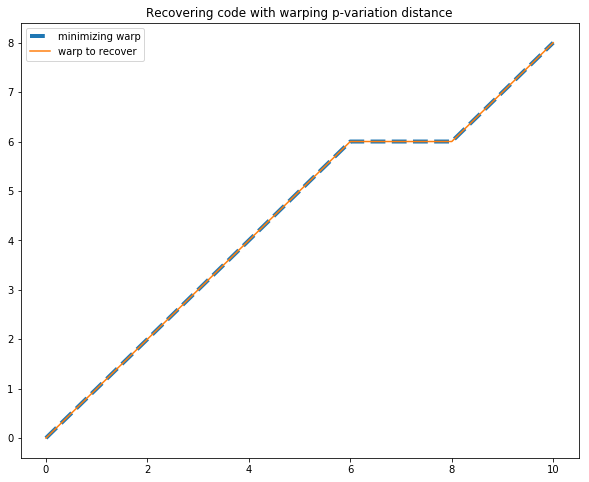

In [110]:
plt.figure(figsize=(10,8))
plt.plot([e[0] for e in best_warp], [e[1] for e in best_warp], linestyle='--', lw=4, label='minimizing warp')
plt.plot(g, label='warp to recover')
plt.legend()
plt.title('Recovering code with warping p-variation distance')
plt.show()

# Possible problems

###  1) The reparameterisation might not be the minimiser (I ve seen examples of this)

### 2) The minimum might not be unique (I've seen examples of this)

### 3) In this application we are fixing the parameterisation of one path (the initial noise) and minimising over all possible reparameterisation of the warped noise, exclusively. The algorithm minimises over two functions, not one. It seems that we should not consider vertical move as we are fixing the parameterisation of the intial noise and varying only the one of the warped noise. In the code this can be easily done by removing the left or right child from every parents. But this needs thought as we need to make sure we reach the final node "(m,n)" anyway, but without never going up, or right, depending on the orientation of the grid.

In [100]:
# this is the code we wish to recover
code = []
for k in range(len(g)):
    code.append((k, g[k]))

In [101]:
code

[(0, 0),
 (1, 0),
 (2, 0),
 (3, 1),
 (4, 2),
 (5, 3),
 (6, 4),
 (7, 5),
 (8, 6),
 (9, 7)]

In [102]:
# this is the p-variation distance along the code
problem.distance(warp=code)

(0.6611925562236646, [])

In [103]:
# this is the best warp found by the algorithm
best_warp

[(0, 0),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 2),
 (5, 3),
 (6, 4),
 (7, 5),
 (8, 6),
 (9, 7)]

In [104]:
# this is the warped p-variation distance btw W and W_rep
problem.distance(warp=best_warp)

(0.6611925562236646, [])